In [1]:
import os
os.chdir('/scratch/sagarsj42')

In [5]:
import time
import pickle
import multiprocessing

import numpy as np
import scipy.spatial as sp
import gensim

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)
        
    def forward(self, inputs):
        out = self.embeddings(inputs)
        ct_size = out.shape[1]
        out = (out.sum(1) / ct_size).view(out.shape[0], -1)
        out = self.linear(out)
        out = self.activation_function(out)
        
        return out
    
    def get_embedding(self, word, vocab):
        word_ind = torch.tensor(vocab.index(word), dtype=torch.long)
        return self.embeddings(word_ind).view(1, -1)

In [30]:
checkpoint = torch.load('checkpoint-0-400000.pt')

vocab = checkpoint['vocab']
print('Vocab size', len(vocab))
print('Samples', vocab[:5])

model_args = checkpoint['model_args']
model = CBOW(**model_args)
print('Model initialized with args',model_args, model)

model.load_state_dict(checkpoint['state_dict'])
model.eval()
print('Model loaded with trained weights', model.state_dict())

Vocab size 50933
Samples ['<UNK>', 'we', 'got', 'this', 'for']
Model initialized with args {'vocab_size': 50933, 'embedding_dim': 750} CBOW(
  (embeddings): Embedding(50933, 750)
  (linear): Linear(in_features=750, out_features=50933, bias=True)
  (activation_function): LogSoftmax(dim=-1)
)
Model loaded with trained weights OrderedDict([('embeddings.weight', tensor([[-1.3609, -1.2371,  1.5244,  ..., -0.5109, -1.2999,  1.2857],
        [-1.0643,  1.2375, -0.0253,  ...,  0.8711, -1.9111,  2.0883],
        [ 0.7158,  1.1279,  0.0361,  ..., -0.9292, -0.8036,  0.1707],
        ...,
        [-1.3106, -0.6954,  0.1102,  ...,  0.3066, -0.1432,  2.4817],
        [ 0.3622,  1.3063,  0.2187,  ..., -0.4506,  0.9396,  0.2432],
        [ 0.1947,  1.4625, -1.4629,  ...,  0.5071,  0.8568,  2.4582]])), ('linear.weight', tensor([[-0.0098,  0.0106,  0.0102,  ...,  0.0159,  0.0119, -0.0045],
        [ 0.0162,  0.0078,  0.0275,  ...,  0.0204, -0.0281, -0.0201],
        [ 0.0026, -0.0146, -0.0300,  ...,  0.

In [33]:
e = np.zeros((model_args['vocab_size'], model_args['embedding_dim']))

for i, word in enumerate(vocab):
    we = model.get_embedding(word, vocab).detach().numpy().reshape(-1)
    e[i, :] = we

e.shape

(50933, 750)

In [18]:
w1_e = model.get_embedding('camera', vocab).detach().numpy().reshape(-1, 1)
w1_e.shape

(750, 1)

In [19]:
distances = list()
for w in vocab:
    w2_e = model.get_embedding(w, vocab).detach().numpy().reshape(-1, 1)
    distances.append((sp.distance.cosine(w1_e, w2_e), w))
    
distances[:10]

[(1.0272411964833736, '<UNK>'),
 (0.9727835580706596, 'we'),
 (1.009438969194889, 'got'),
 (0.9721494801342487, 'this'),
 (1.0143909910693765, 'for'),
 (1.0185319855809212, 'my'),
 (0.9732594452798367, 'husband'),
 (1.0149310305714607, 'who'),
 (0.9494607485830784, 'is'),
 (1.0489345975220203, 'an')]

In [20]:
distances.sort(key=lambda t: t[0])
distances[:11]

[(0.0, 'camera'),
 (0.8398945927619934, 'confusions'),
 (0.8587876707315445, 'trifling'),
 (0.8610303401947021, 'mountaineering'),
 (0.8615380823612213, 'floats'),
 (0.8631294816732407, 'daffodil'),
 (0.8656760454177856, 'kaleidoscopes'),
 (0.86722432076931, 'misrepresent'),
 (0.8683715611696243, 'liability'),
 (0.8704690933227539, 'hauled'),
 (0.8712237328290939, 'weavers')]

In [21]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    '~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)

w1_e = word2vec['camera']
w1_e.shape

(300,)

In [24]:
distances = list()
for word in vocab:
    try:
        w2_e = word2vec[word]
    except KeyError:
        w2_e = np.zeros(300)
    distances.append((sp.distance.cosine(w1_e, w2_e), word))
    
distances[:10]

/home2/sagarsj42/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[(nan, '<UNK>'),
 (0.9034783244132996, 'we'),
 (0.8751401305198669, 'got'),
 (0.9668513834476471, 'this'),
 (1.0030541874002665, 'for'),
 (0.8633989840745926, 'my'),
 (0.8664259761571884, 'husband'),
 (0.9332376345992088, 'who'),
 (0.9353648945689201, 'is'),
 (0.9466216117143631, 'an')]

In [25]:
distances.sort(key=lambda t: t[0])
distances[:11]

[(nan, '<UNK>'),
 (0.0, 'camera'),
 (0.403339147567749, 'viewfinder'),
 (0.45716017484664917, 'cam'),
 (0.4986976385116577, 'lenses'),
 (0.5297282636165619, 'photos'),
 (0.5543881356716156, 'shutterbug'),
 (0.5810834169387817, 'stereoscopic'),
 (0.5813919603824615, 'laptop'),
 (0.5818691253662109, 'footages'),
 (0.5951479077339172, 'eyepieces')]

In [34]:
e_pca = PCA(n_components=25).fit_transform(e)
e_pca.shape

(50933, 25)

In [35]:
e_tsne = TSNE(n_components=2, perplexity=10, 
              metric='cosine', init='pca', square_distances=True,
              n_jobs=multiprocessing.cpu_count()).fit_transform(e_pca)
e_tsne.shape

(50933, 2)

In [36]:
select_words = ['jackhammered', 'sharper', 'amid', 'secretion', 'chapeau']
select_ind = [vocab.index(word) for word in select_words]
word_embeds = [e_tsne[i] for i in select_ind]
select_ind

[50397, 4403, 23402, 40100, 35584]

In [37]:
word_distances = dict()

for w, w1_e in zip(select_words, word_embeds):
    distances = list()
    for i in range(50933):
        if vocab.index(w) != i:
            w2_e = e_tsne[i]
            distances.append((vocab[i], w2_e, sp.distance.cosine(w1_e, w2_e)))
    
    distances.sort(key=lambda t: t[2])
    word_distances[w] = (w1_e, distances[:10])

word_distances

{'jackhammered': (array([-21.945923 ,   4.8959875], dtype=float32),
  [('options', array([-22.945942,   5.120926], dtype=float32), 0.0),
   ('terminating', array([-47.9895  ,  10.691243], dtype=float32), 0.0),
   ('wrangle', array([-47.933987,  10.68716 ], dtype=float32), 0.0),
   ('tensile', array([-32.7089   ,   7.3003573], dtype=float32), 0.0),
   ('unequalized', array([-67.46954 ,  15.030867], dtype=float32), 0.0),
   ('ebbing', array([-48.68436 ,  10.867767], dtype=float32), 0.0),
   ('timberland', array([-59.49389 ,  13.284376], dtype=float32), 0.0),
   ('tyke',
    array([-67.40203 ,  15.066281], dtype=float32),
    5.960464477539063e-08),
   ('scrawny',
    array([-32.668983,   7.278216], dtype=float32),
    5.960464477539063e-08),
   ('qualitative',
    array([-12.106121 ,   2.7003853], dtype=float32),
    1.1920928955078125e-07)]),
 'sharper': (array([ 48.15453 , -26.228525], dtype=float32),
  [('axed', array([ 38.19949 , -20.811207], dtype=float32), 0.0),
   ('justing', arra

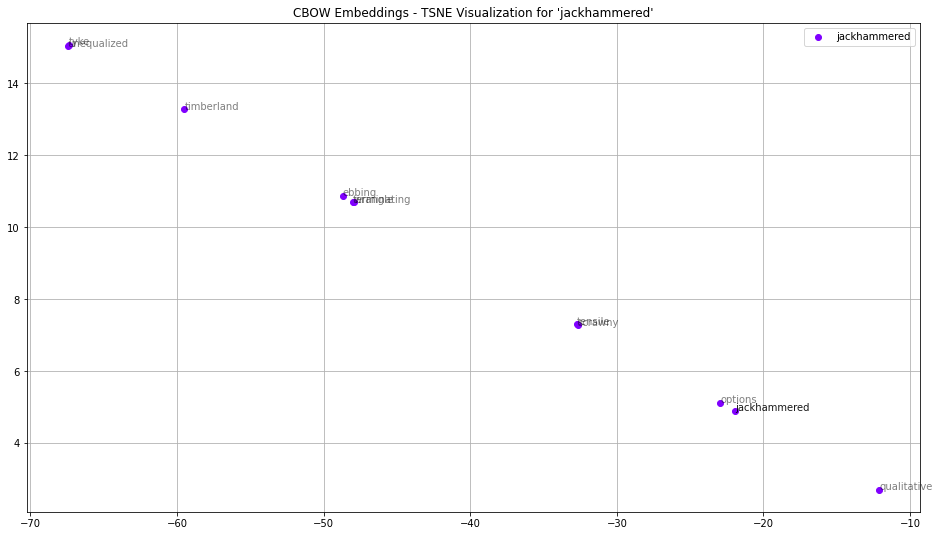

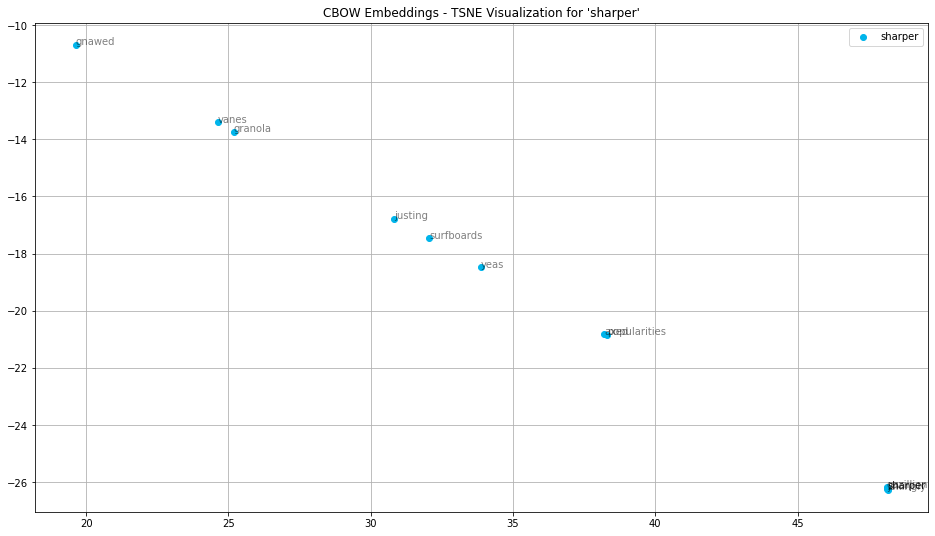

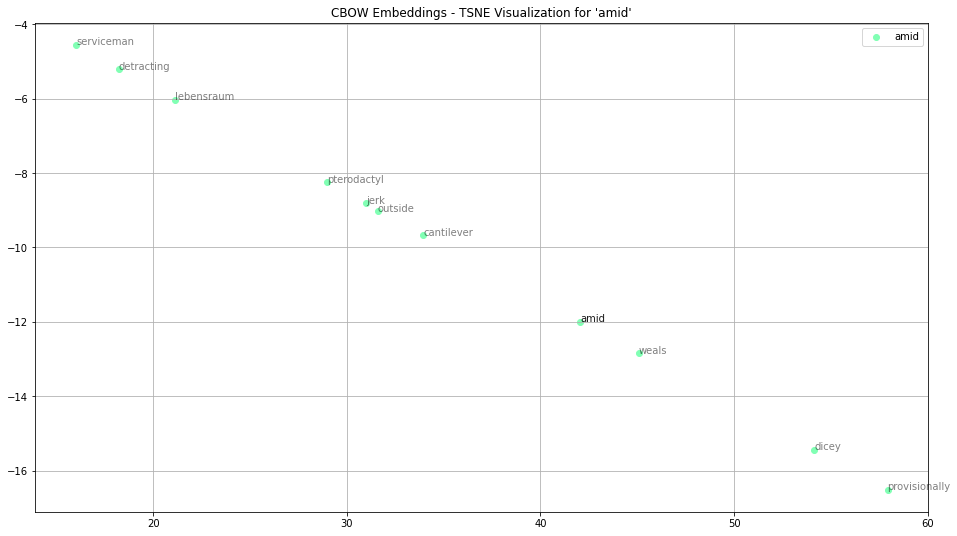

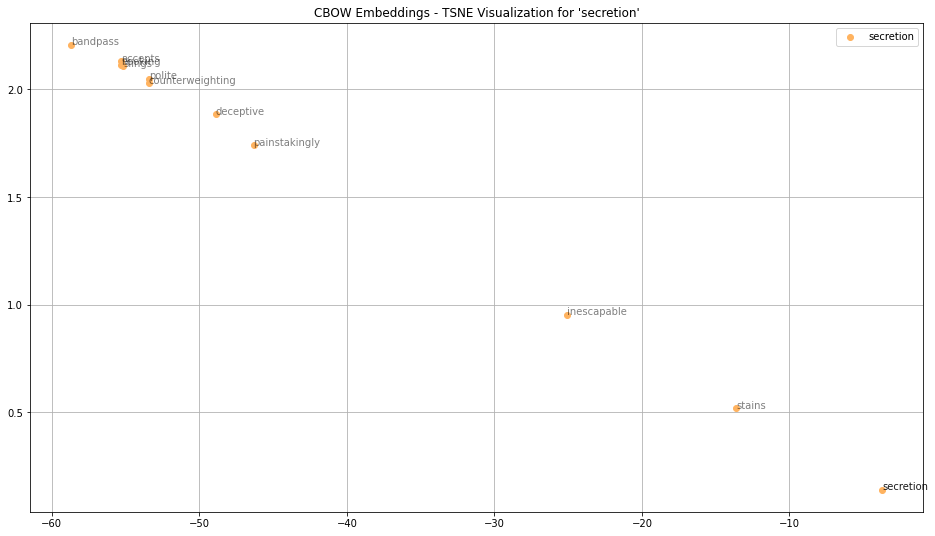

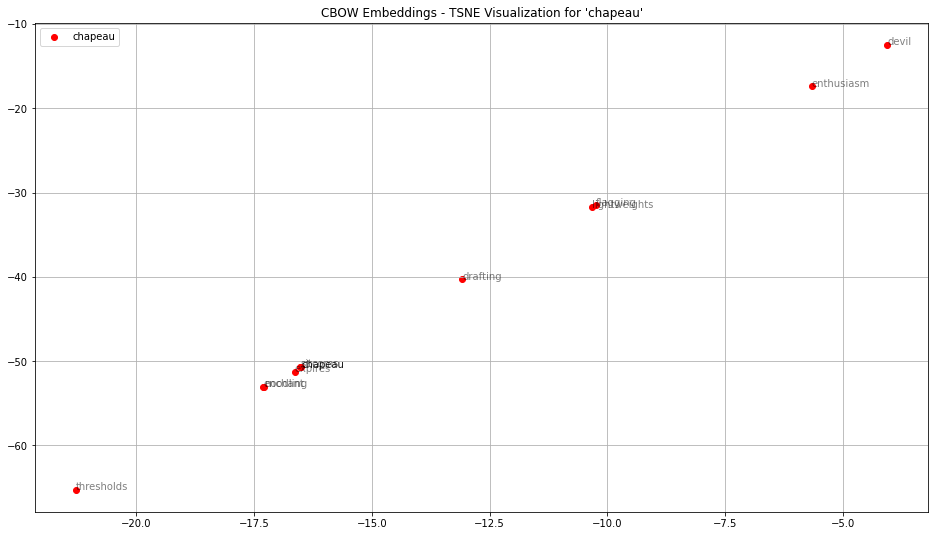

In [38]:
colors = cm.rainbow(np.linspace(0, 1, 5))

for word, color in zip(word_distances, colors):
    plt.figure(figsize=(16, 9))
    w1_e = word_distances[word][0]
    distances = word_distances[word][1]
    x = w1_e[0]
    y = w1_e[1]
    
    plt.scatter(x, y, label=word, color=color)
    plt.annotate(word, alpha=0.9, xy=(x, y))
    
    for d in distances:
        word2 = d[0]
        w2_e = d[1]
        x = w2_e[0]
        y = w2_e[1]
        
        plt.scatter(x, y, color=color)
        plt.annotate(word2, alpha=0.5, xy=(x, y))
    
    plt.title('CBOW Embeddings - TSNE Visualization for \'' + word + '\'')
    plt.legend()
    plt.grid()
    plt.savefig('cbow-'+word+'.png')
    plt.show()